In [18]:
from __future__ import annotations

import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from numpy import random

%matplotlib inline

In [13]:
class Value:
    def __init__(self, data: float | int, _children: tuple[Value]=(), _op: str='', label: str=''):
        self.data = data
        self.grad = .0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self: Value) -> str:
        return f"Value(data={self.data})"
    
    def __neg__(self) -> Value:
        return self * -1
    
    def __add__(self, other: Value | float | int) -> Value:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other: Value | float | int) -> Value:
        return self.__add__(other)
    
    def __sub__(self, other: Value | float | int) -> Value:
        return self + (-other)
    
    def __rsub__(self, other: Value | float | int) -> Value:
        return self.__sub__(other)
        
    def __mul__(self, other: Value | float | int) -> Value:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other: Value | float | int) -> Value:
        return self.__mul__(other)
    
    def __truediv__(self, other: Value | float | int) -> Value:
        other = other if isinstance(other, Value) else Value(other)
        return self * other ** -1
    
    def __pow__(self, other: Value | float | int) -> Value:
        assert isinstance(other, (float, int)), "Exponent must be a scalar"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self) -> Value:
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self) -> Value:
        out = Value(math.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self) -> None:
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = f"{{ {n.label} | data {n.data} | grad {n.grad}}}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [12]:
a = Value(2.0)
b = Value(4.0)
a / b 

Value(data=0.5)

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

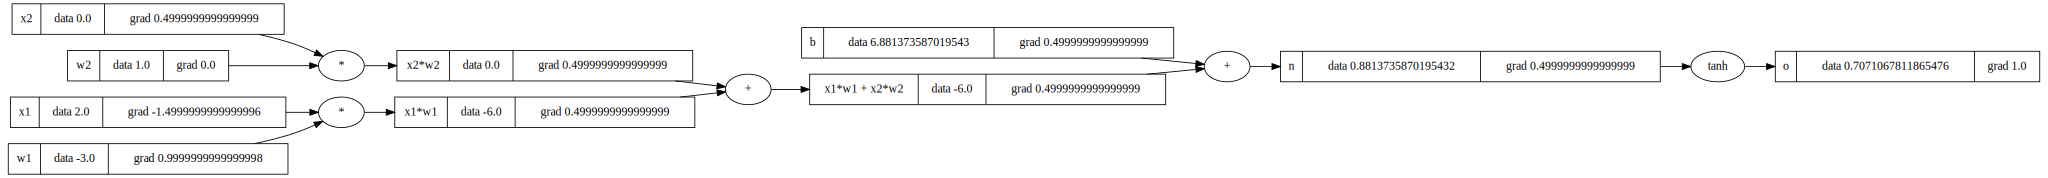

In [15]:
draw_dot(o)

In [16]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ------
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# --------
o.label = 'o'
o.backward()

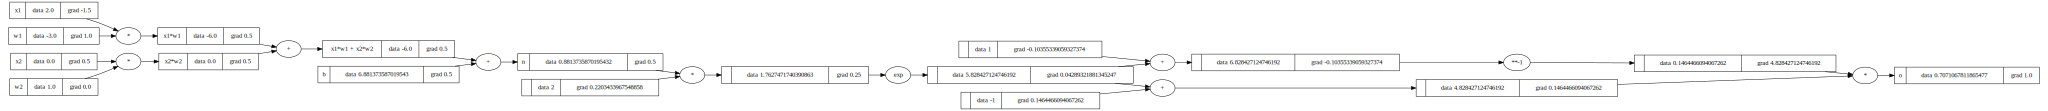

In [17]:
draw_dot(o)

In [242]:
class Neuron:
    def __init__(self, num_inputs: int, layer_num: int, neuron_num: int):
        self.w = [Value(random.uniform(-1.0, 1.0), label=f"l{layer_num}n{neuron_num}w{i}") for i in range(num_inputs)]
        self.b = Value(random.uniform(-1.0, 1.0), label=f"l{layer_num}n{neuron_num}b")

    def __call__(self, x: list[float | int | Value], example_num: int) -> Value:
        assert len(x) == len(self.w), f"Input size must be equal to weight size x.size = {len(x)}, w.size = {len(self.w)}"
        act = sum((self.w[i] * (x[i] if isinstance(x[i], Value) else Value(x[i], label=f"e{example_num}x{i}")) for i in range(len(x))), self.b) 
        out = act.tanh()
        return out

    def parameters(self) -> list[Value]:
        return self.w + [self.b]
    
class Layer:
    def __init__(self, num_inputs: int, num_neurons: int, layer_num: int):
        self.neurons = [Neuron(num_inputs, layer_num, i) for i in range(num_neurons)]
    
    def __call__(self, x: list[float | int | Value], example_num: int) -> list[Value]:
        outs = [n(x, example_num) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self) -> list[Value]:
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, num_inputs: int, num_outputs: list[int]):
        sz = [num_inputs] + num_outputs
        self.layers = [Layer(sz[i], sz[i+1], i) for i in range(len(num_outputs))]

    def __call__(self, x: list[float | int | Value], example_num: int):
        for layer in self.layers:
            x = layer(x, example_num)
        return x
    
    def parameters(self) -> list[Value]:
        return [p for layer in self.layers for p in layer.parameters()]

In [243]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
n = MLP(3, [4, 4, 1])

In [254]:
alpha = 0.1
for k in range(20):
    ypred = [n(xs[i], i) for i in range(len(xs))]
    loss = sum(((ygt - yout)**2 for ygt, yout in zip(ys, ypred)))
    print(f"Current loss: {loss.data}")
    params = n.parameters()

    for p in params:
        p.grad = 0.0
    loss.backward()

    for p in params:
        p.data -= alpha * p.grad

Current loss: 0.0019874347071492412
Current loss: 0.0019747721800126407
Current loss: 0.0019622674295952424
Current loss: 0.001949917549112118
Current loss: 0.0019377197023753778
Current loss: 0.0019256711216717884
Current loss: 0.0019137691057163507
Current loss: 0.0019020110176785877
Current loss: 0.0018903942832785982
Current loss: 0.0018789163889500404
Current loss: 0.0018675748800672807
Current loss: 0.0018563673592340802
Current loss: 0.001845291484631498
Current loss: 0.0018343449684224385
Current loss: 0.0018235255752107882
Current loss: 0.0018128311205527544
Current loss: 0.0018022594695186718
Current loss: 0.0017918085353029476
Current loss: 0.0017814762778805388
Current loss: 0.0017712607027080486
